In [63]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
%aimport vae
%aimport distributions
%aimport distribution_metrics
%aimport y_utils
%aimport samplers
from y_utils import *
from vae import VAE
from samplers import *
from distributions import Banana, Funnel
from distribution_metrics import sliced_total_variation, total_variation_1d, wasserstein_metric
import torch
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from time import time
from tqdm import tqdm

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda


In [66]:
Ds = [2, 4, 8, 12, 16, 24, 32]
targets = {D: Banana(dim=D, sigma=5.0, b=0.02, device=device) for D in Ds}

In [67]:
def get_model(D):
    hidden_dims = (128, 128, 128, 128)
    latent_dim = D
    return VAE(data_dim=D, hidden_dims=hidden_dims, latent_dim=latent_dim, device=device)

CPU times: total: 5min 9s
Wall time: 5min 10s


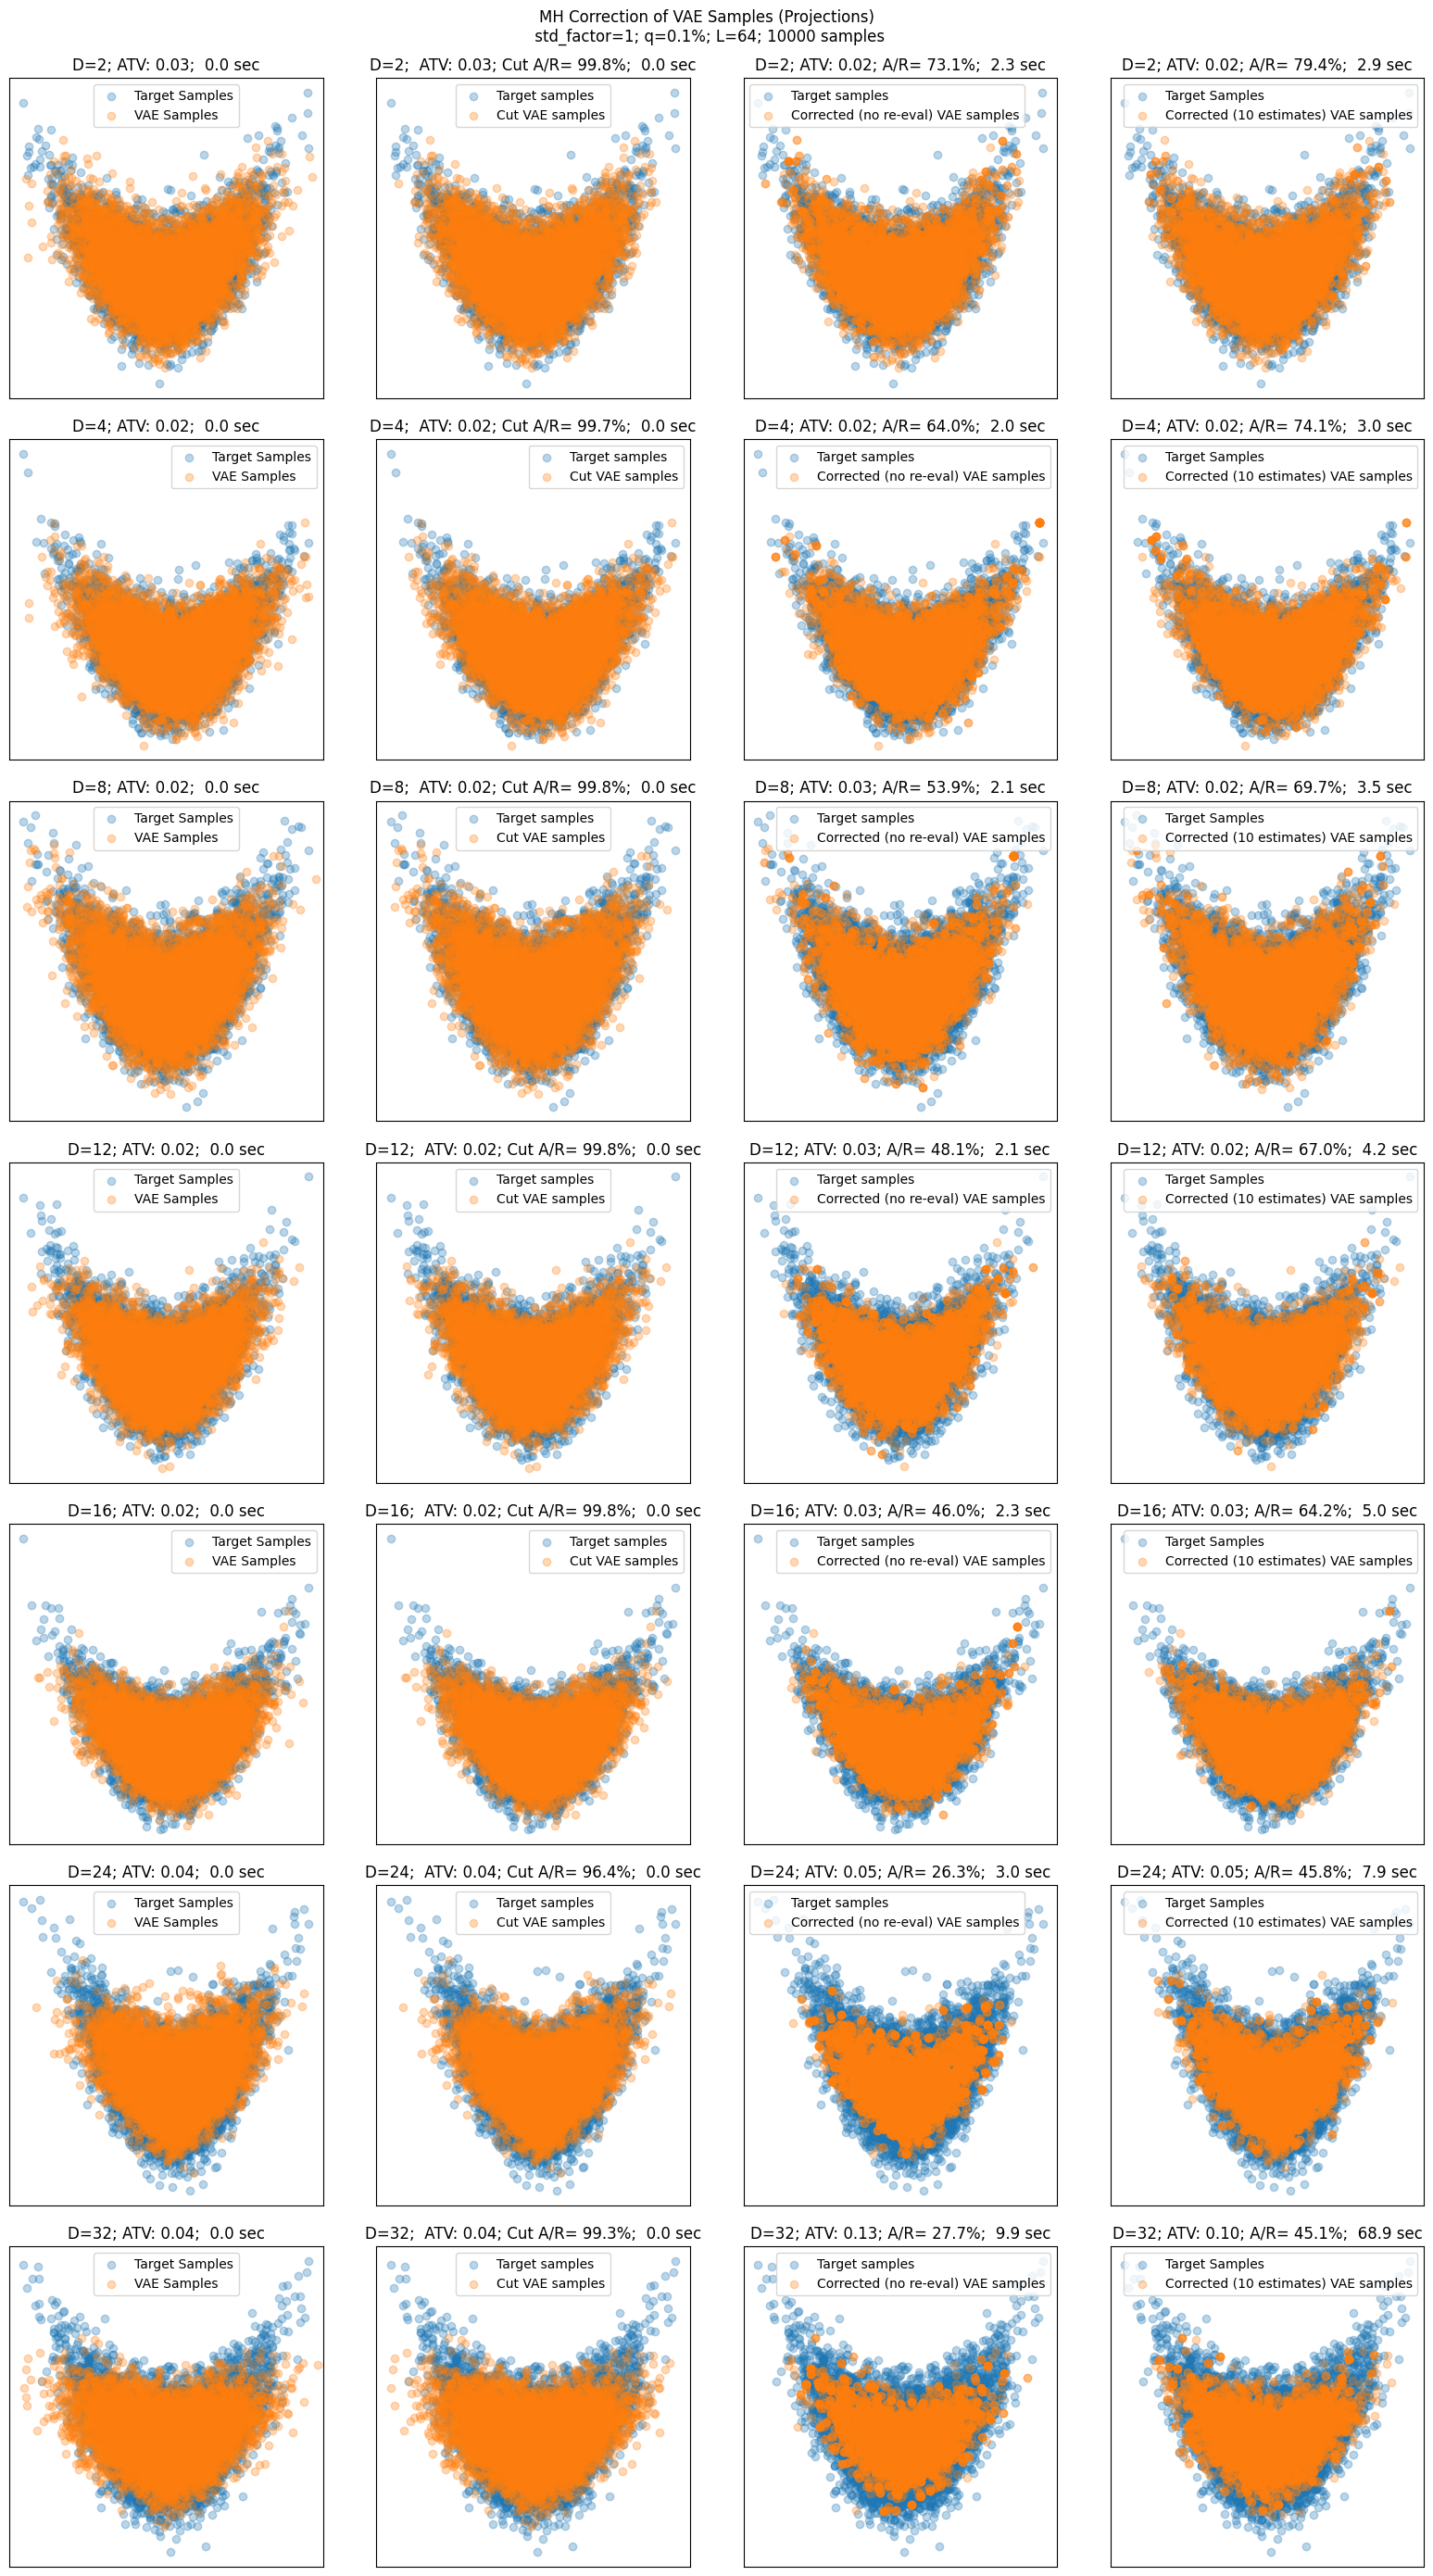

In [7]:
%%time

def plot_mh_samples_for_all_Ds(N, L, std_factor, q=0, use_reeval=False, use_multiple=False):
    proj_dims = (0, 1)
    alpha = 0.3

    ncols = 3 + use_reeval + use_multiple
    nrows = len(Ds)
    fig, axss = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4 * ncols, 4 * nrows))
    fig.suptitle(f'MH Correction of VAE Samples (Projections)\n std_factor={std_factor}; q={100*q:0.1f}%; L={L}; {N} samples', y=1.0)
    fig.tight_layout()
    
    for D, axs in zip(Ds, axss):
        target = targets[D]
        model = get_model(D)
        model.load_knowledge(f'models/{model}_banana.pt')
        model.set_std_factor(std_factor)
        proposer = lambda sample_shape : model.sample(sample_shape)
        proposal_log_prob_estimator = lambda x : model.iw_log_marginal_estimate(x, L=L, batch_L=32)

        target_samples = target.sample((N,))
        stv_estimator = lambda samples : sliced_total_variation(target_samples, samples, n_kde_samples=300, n_projections=2*D)

        # Generate model samples
        _start_time = time()
        model_samples = model.sample((N,))
        model_time = time() - _start_time
        model_atv = stv_estimator(model_samples)

        # Remove unlikely samples
        cutoff_quantile =  target.log_prob(target_samples).quantile(q).item()
        _start_time = time()
        cut_acc_rate, cut_indicies = log_prob_cutoff_filter(target, cutoff_quantile, model_samples)
        cut_samples = model_samples[cut_indicies]
        cutoff_time = time() - _start_time
        cut_atv = stv_estimator(cut_samples)

        # Run Metropolis-Hastings algorithm
        _start_time = time()
        mh_acc_rate, mh_indicies = metropolis_hastings_filter(target, cut_samples, proposal_log_prob_estimator)
        mh_samples = cut_samples[mh_indicies]
        mh_time = time() - _start_time
        mh_atv = stv_estimator(mh_samples)

        # Run Metropolis-Hastings algorithm using multiple estimates
        if use_multiple:
            n_estimates = 10
            _start_time = time()
            mhm_acc_rate, mhm_indicies = metropolis_hastings_filter(target, cut_samples, proposal_log_prob_estimator, n_estimates=n_estimates)
            mhm_samples = cut_samples[mhm_indicies]
            mhm_time = time() - _start_time
            mhm_atv = stv_estimator(mhm_samples)

        # Plot
        ax1, ax2, ax3 = axs[:3]

        ax1.scatter(*pl(target_samples[:, proj_dims]), alpha=alpha, label='Target Samples')
        ax1.scatter(*pl(model_samples[:, proj_dims]), alpha=alpha, label='VAE Samples')
        ax1.set_title(f'D={D}; ATV:{model_atv: 0.2f}; {model_time: 0.1f} sec')

        ax2.scatter(*pl(target_samples[:, proj_dims]), alpha=alpha, label='Target samples')
        ax2.scatter(*pl(cut_samples[:, proj_dims]), alpha=alpha, label='Cut VAE samples')
        ax2.set_title(f'D={D};  ATV:{cut_atv: 0.2f}; Cut A/R={100 * cut_acc_rate: 0.1f}%; {cutoff_time: 0.1f} sec')  # cutoff time is currently 0.0 sec
        
        ax3.scatter(*pl(target_samples[:, proj_dims]), alpha=alpha, label='Target samples')
        ax3.scatter(*pl(mh_samples[:, proj_dims]), alpha=alpha, label='Corrected (no re-eval) VAE samples')
        ax3.set_title(f'D={D}; ATV:{mh_atv: 0.2f}; A/R={100 * mh_acc_rate: 0.1f}%; {mh_time: 0.1f} sec')
        
        if use_multiple:
            ax4 = axs[3]
            ax4.scatter(*pl(target_samples[:, proj_dims]), alpha=alpha, label='Target Samples')
            ax4.scatter(*pl(mhm_samples[:, proj_dims]), alpha=alpha, label=f'Corrected ({n_estimates} estimates) VAE samples')
            ax4.set_title(f'D={D}; ATV:{mhm_atv: 0.2f}; A/R={100 * mhm_acc_rate: 0.1f}%; {mhm_time: 0.1f} sec')

        for ax in axs:
            ax.set_xlim(ax2.get_xlim())
            ax.set_ylim(ax2.get_ylim())
            ax.set_xticks([])
            ax.set_yticks([])
            ax.legend()

plot_mh_samples_for_all_Ds(N=10000, L=64, std_factor=1, q=0.001, use_reeval=False, use_multiple=True)

CPU times: total: 3.38 s
Wall time: 3.4 s


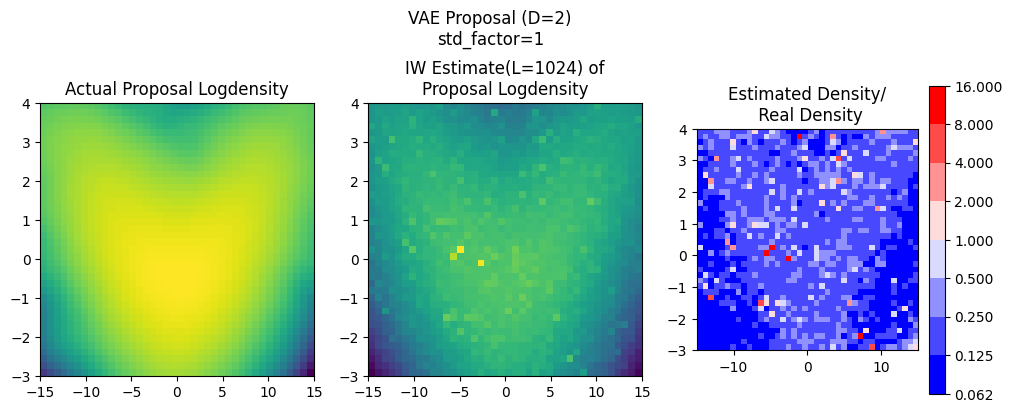

In [10]:
%%time

from scipy.stats import gaussian_kde
from matplotlib.colors import TwoSlopeNorm
import matplotlib.colors as mcolors

def evaluate_iw_proposal_estimator_2d():
    std_factor = 1
    L = 1024

    D = 2
    model = get_model(D)
    model.load_knowledge(f'models/{model}_banana.pt')
    model.set_std_factor(std_factor)
    target = targets[D]
    
    N = 20000
    model_samples = to_numpy(model.sample((N, )))
    proposal_kernel = gaussian_kde(model_samples.T, bw_method='scott')
    proposal_kernel.set_bandwidth(proposal_kernel.factor * 1.5)
    proposal_log_estimate = lambda x: to_numpy(model.iw_log_marginal_estimate(torch.tensor(x.T, dtype=torch.float).to(device), L=L, batch_L=512))
    
    xlim = (-15, 15)
    ylim = (-3, 4)
    d = 40
    x = np.linspace(*xlim, d)
    y = np.linspace(*ylim, d)
    X, Y = np.meshgrid(x, y)
    points = np.vstack((X.ravel(), Y.ravel()))

    real_logd = proposal_kernel.logpdf(points).reshape(d, d)
    estimated_logd = proposal_log_estimate(points).reshape(d, d)
    target_logd = target.log_prob(points.T).reshape(d, d)
    
    ratio = (xlim[1] - xlim[0]) / (ylim[1] - ylim[0])
    fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
    ax1 = axs[0]
    ax2 = axs[1]
    ax3 = axs[2]
    #ax4 = axs[3]
    
    img1 = ax1.imshow(real_logd, origin='lower', extent=[*xlim, *ylim])
    ax1.set_aspect(ratio)
    ax1.set_title(f'Actual Proposal Logdensity')
    
    img2 = ax2.imshow(estimated_logd, origin='lower', extent=[*xlim, *ylim])
    ax2.set_aspect(ratio)
    ax2.set_title(f'IW Estimate(L={L}) of\nProposal Logdensity')

    Z = estimated_logd - real_logd
    #vmin = Z.min()
    #vmax = Z.max()
    #vcenter = 0
    #norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    boundaries = np.log(np.array([1/16, 1/8, 1/4, 1/2, 1, 2, 4, 8, 16]))
    cmap = plt.get_cmap('bwr')
    norm = mcolors.BoundaryNorm(boundaries=boundaries, ncolors=cmap.N, clip=True)
    img3 = ax3.imshow(Z, cmap=cmap, norm=norm, origin='lower', extent=[*xlim, *ylim])
    #ax2.set_xticks([])
    #ax2.set_yticks([])
    ax3.set_aspect(ratio)
    ax3.set_title(f'Estimated Density/\n Real Density')
    cbar = fig.colorbar(img3, ax=ax3, orientation='vertical', pad=0.04)
    #ticks = [0.01, 0.05, 0.25, 1, 1.1, 2, 4, 8]
    #cbar.set_ticks([np.log(x) for x in ticks])
    cbar.set_ticklabels([f'{(np.exp(val)):.3f}' for val in cbar.get_ticks()])
    '''
    Z = target_logd - estimated_logd
    img4 = ax4.imshow(Z, origin='lower', extent=[*xlim, *ylim])
    #ax2.set_xticks([])
    #ax2.set_yticks([])
    ax4.set_aspect(ratio)
    ax4.set_title(f'Target Density /\n Estimaed Proposal Density')
    cbar = fig.colorbar(img4, ax=ax4, orientation='vertical', pad=0.04)
    '''
    fig.suptitle(f'VAE Proposal (D=2)\nstd_factor={std_factor}', y=1.07)
    

evaluate_iw_proposal_estimator_2d()

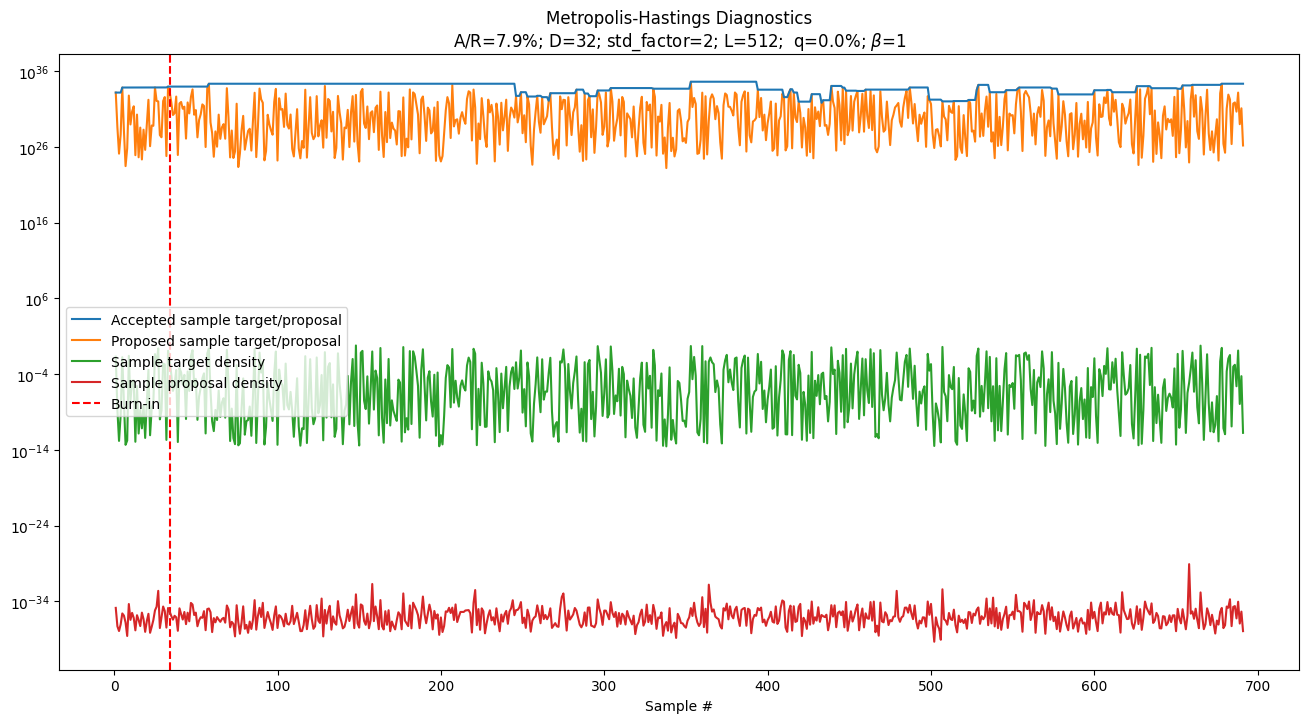

In [11]:
def mh_diagnostics():
    std_factor = 2
    L = 512
    D = 32
    N = 2000
    beta = 1
    
    model = get_model(D)
    model.load_knowledge(f'models/{model}_banana.pt')
    model.set_std_factor(std_factor)
    target = targets[D]
    proposal_log_prob_estimator = lambda x : model.iw_log_marginal_estimate(x, L=L, beta=beta, batch_L=32)

    target_samples = target.sample((N,))
    q = 0.0
    target_quantile = target.log_prob(target_samples).quantile(q)

    proposal_samples = model.sample((N,))
    cut_acc_rate, cut_indicies = log_prob_cutoff_filter(target, target_quantile, proposal_samples)
    mh_acc_rate, mh_indicies = metropolis_hastings_filter(target, proposal_samples[cut_indicies], proposal_log_prob_estimator, visualize=True)
    plt.title(plt.gca().get_title()+rf'; D={D}; std_factor={std_factor}; L={L};  q={100*q}%; $\beta$={beta}')

mh_diagnostics()

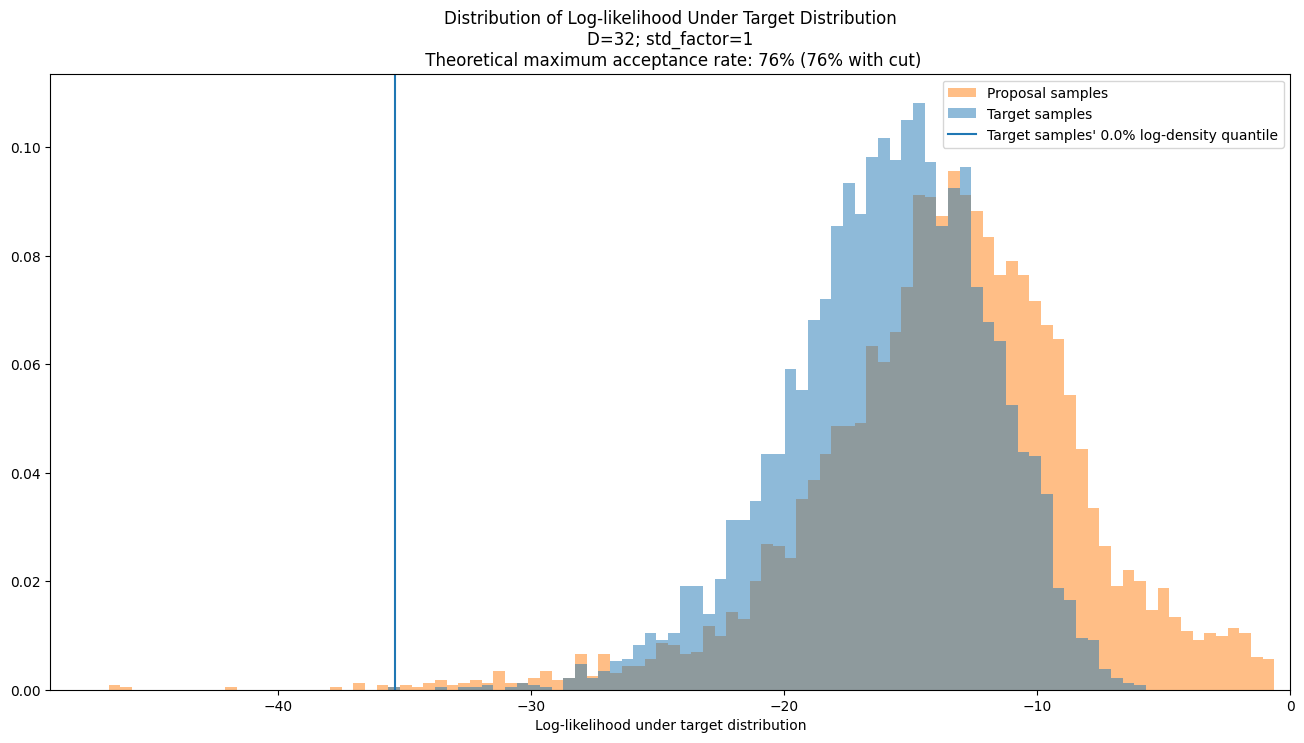

In [23]:
def sample_target_densities():
    D = 32
    std_factor = 1
    L = 512
    beta = 1
    N = 5000
    
    model = get_model(D)
    model.load_knowledge(f'models/{model}_banana.pt')
    model.set_std_factor(std_factor)
    target = targets[D]

    
    target_samples = target.sample((N,))
    model_samples = model.sample((N,))
    proposal_log_prob_estimator = lambda x : model.iw_log_marginal_estimate(x, L=L, beta=beta, batch_L=32)
    mh_ar, mh_sample_indicies = metropolis_hastings_filter(target, model_samples, proposal_log_prob_estimator)
    mh_samples = model_samples[mh_sample_indicies]
    target_log_likelihood = target.log_prob(target_samples)
    proposal_log_likelihood = target.log_prob(model_samples)
    mh_log_likelihood = target.log_prob(mh_samples)
    
    q = 0.0
    target_quantile = target_log_likelihood.quantile(q)
    cut_acc_rate, cut_indicies = log_prob_cutoff_filter(target, target_quantile, model_samples)
    cut_proposal_log_likelihood = target.log_prob(model_samples[cut_indicies])
    max_acc_rate = 1 - total_variation_1d(proposal_log_likelihood, target_log_likelihood)
    max_acc_rate_with_cut = 1 - total_variation_1d(cut_proposal_log_likelihood, target_log_likelihood)
    
    fig, ax = plt.subplots(figsize=(16, 8))

    # proposal_log_prob = proposal_log_prob_estimator(target_samples)
    ax.hist(
        [to_numpy(target_log_likelihood), to_numpy(proposal_log_likelihood)], #, to_numpy(cut_proposal_log_likelihood)],
        bins=100,
        histtype='stepfilled',
        alpha=0.5,
        label=['Target samples', 'Proposal samples'], #, 'Cut proposal samples'],
        density=True
    )
    ax.axvline(target_quantile.item(), label=f"Target samples' {100*q}% log-density quantile")
    #sns.histplot(to_numpy(proposal_log_likelihood), ax=ax, label='Proposal samples')
    
    #proposal_log_prob = proposal_log_prob_estimator(model_samples)
    #target_log_prob = target.log_prob(model_samples)
    #ax.scatter(to_numpy(target_log_prob.exp()), to_numpy(proposal_log_prob.exp()), alpha=0.5, label='Model samples')
    
    # ax.set_xscale('log')
    ax.set_xlabel('Log-likelihood under target distribution')
    ax.set_xlim(left=max(ax.get_xlim()[0], -80), right=0)
    #ax.set_ylabel('Proposal density')
    ax.set_title(f'Distribution of Log-likelihood Under Target Distribution\nD={D}; std_factor={std_factor}\n Theoretical maximum acceptance rate: {max_acc_rate * 100:0.0f}% ({max_acc_rate_with_cut * 100:0.0f}% with cut)')
    ax.legend()

sample_target_densities()

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.57s/it]


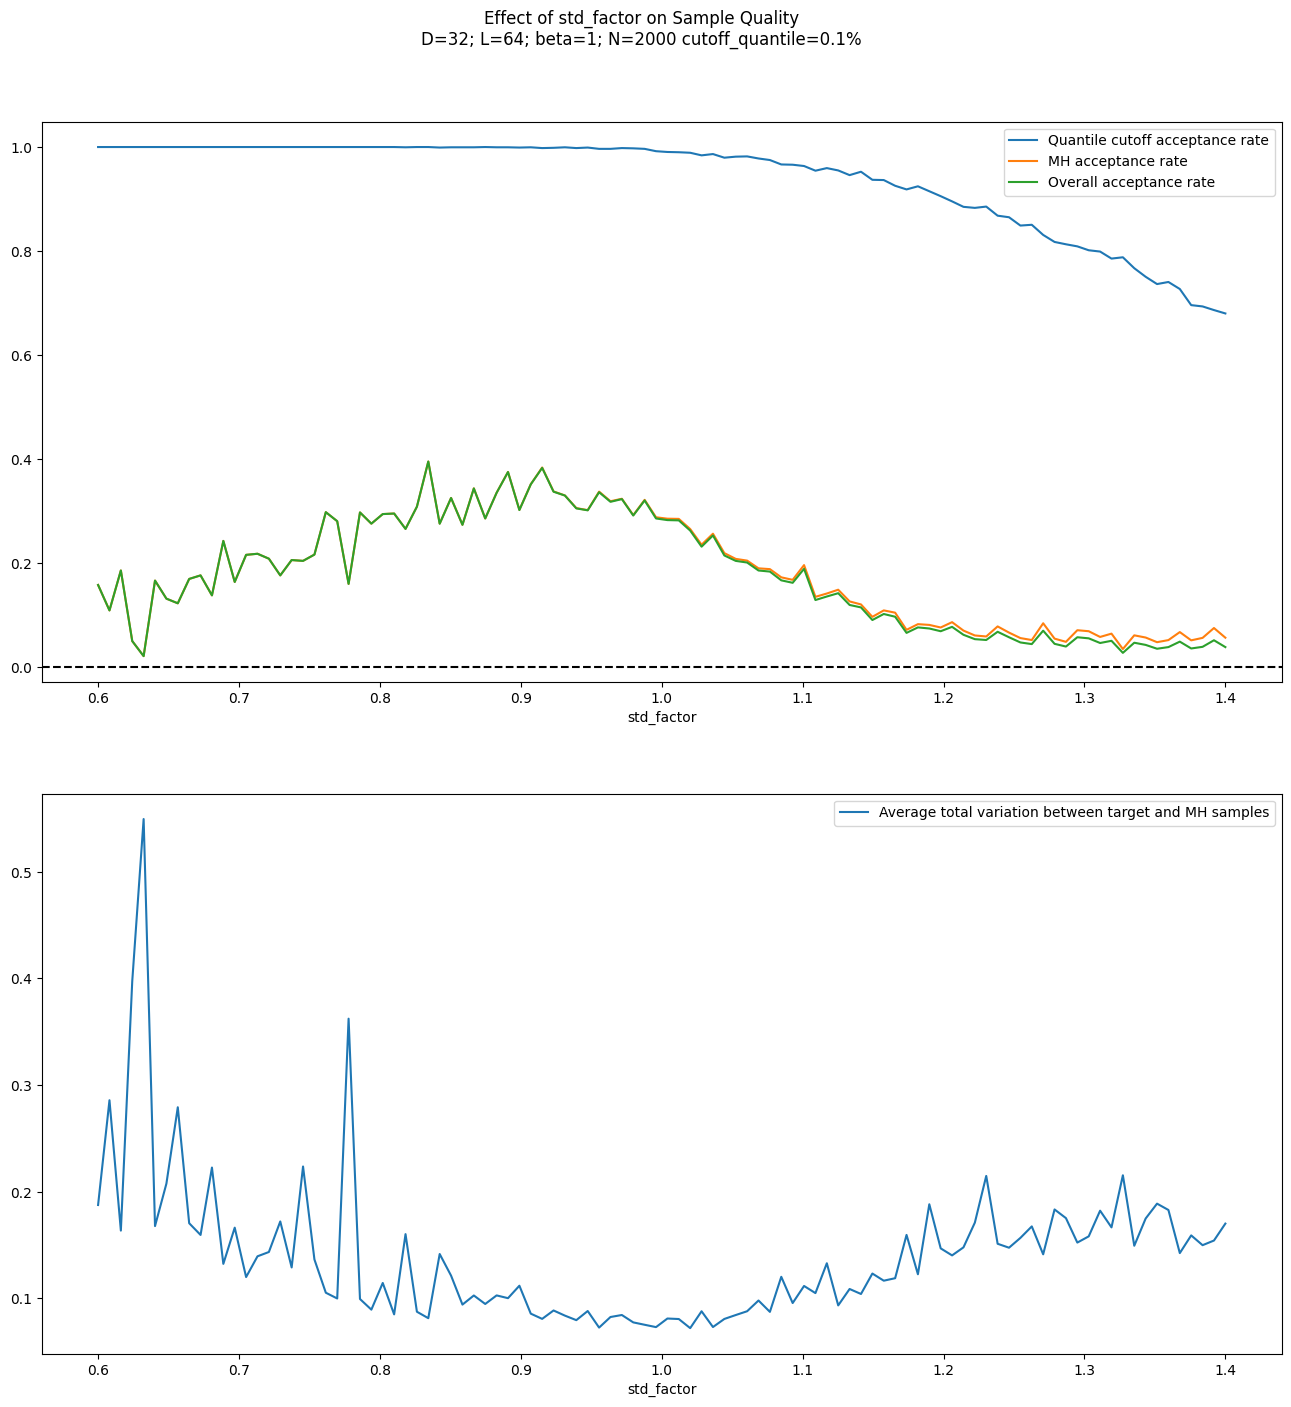

In [11]:
def choose_std_factor():
    D = 32
    L = 64
    beta = 1
    N = 2000

    model = get_model(D)
    model.load_knowledge(f'models/{model}_banana.pt')
    target = targets[D]
    proposal_log_prob_estimator = lambda x : model.iw_log_marginal_estimate(x, L=L, beta=beta, batch_L=32)
    
    cutoff_quantile = 0.001
    target_samples = target.sample((N,))
    cutoff_log_prob = target.log_prob(target_samples).quantile(cutoff_quantile)
    
    std_factor_options = np.linspace(0.6, 1.4, 100)
    cutoff_acc_rates = []
    mh_acc_rates = []
    atvs = []
    for std_factor in tqdm(std_factor_options):
        model.set_std_factor(std_factor)
        proposal_samples = model.sample((N,))
        cutoff_acc_rate, cut_indicies = log_prob_cutoff_filter(target, cutoff_log_prob, proposal_samples)
        cut_proposal_samples = proposal_samples[round2_indicies]
        mh_acc_rate, mh_indicies = metropolis_hastings_filter(target, cut_proposal_samples, proposal_log_prob_estimator)
        mh_samples = proposal_samples[mh_indicies]
        atv = sliced_total_variation(target_samples, mh_samples, n_kde_samples=100, n_projections=2 * D)
        cutoff_acc_rates.append(cutoff_acc_rate)
        mh_acc_rates.append(mh_acc_rate)
        atvs.append(atv)
                                      
    cutoff_acc_rates = np.array(cutoff_acc_rates)
    mh_acc_rates = np.array(mh_acc_rates)
    overall_acc_rates = cutoff_acc_rates * mh_acc_rates

    fig, axs = plt.subplots(figsize=(16, 16), nrows=2)
    ax = axs[0]
    ax.plot(std_factor_options, cutoff_acc_rates, label='Quantile cutoff acceptance rate')
    ax.plot(std_factor_options, mh_acc_rates, label='MH acceptance rate')
    ax.plot(std_factor_options, overall_acc_rates, label='Overall acceptance rate')
    ax.axhline(0, color='black', linestyle='--')
    ax.set_xlabel('std_factor')
    ax.legend()
    ax = axs[1]
    ax.plot(std_factor_options, atvs, label='Average total variation between target and MH samples')
    ax.set_xlabel('std_factor')
    ax.legend()
    plt.suptitle(f'Effect of std_factor on Sample Quality\nD={D}; L={L}; beta={beta}; N={N} cutoff_quantile={100 * cutoff_quantile}%', y=0.95)

choose_std_factor()

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:15<00:00, 27.90s/it]


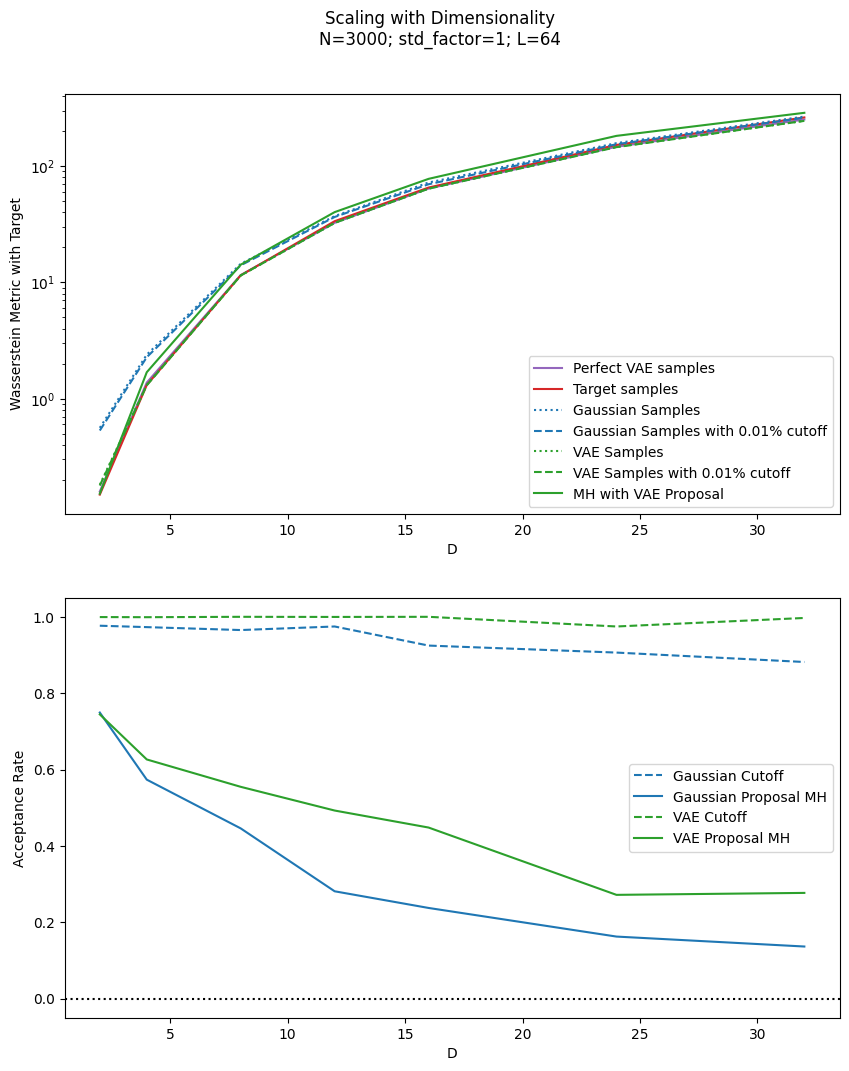

In [73]:
# %%time

def atv_benchmark():
    L = 64
    beta = 1
    N = 3000
    q = 0.0001
    std_factor = 1

    metric = 'wasserstein'

    gaussian_scores = []
    cut_gaussian_ars = np.zeros(len(Ds))
    cut_gaussian_scores = []
    mh_gaussian_ars = np.zeros(len(Ds))
    mh_gaussian_scores = []
    vae_scores = []
    cut_vae_ars = np.zeros(len(Ds))
    cut_vae_scores = []
    mh_vae_ars = np.zeros(len(Ds))
    mh_vae_scores = []
    perfect_vae_scores = []
    self_scores = []
    for i, D in enumerate(tqdm(Ds)):
        target = targets[D]
        model = get_model(D)
        model.load_knowledge(f'models/{model}_banana.pt')
        model.set_std_factor(std_factor)
        
        target_samples = target.sample((N,))
        target_log_likelihood = target.log_prob(target_samples)
        target_quantile = target_log_likelihood.quantile(q)

        if metric == 'wasserstein':
            metric_estimator = lambda samples : wasserstein_metric(target_samples, samples)
            metric_name = 'Wasserstein Metric'
        if metric == 'sliced total variation':
            metric_estimator = lambda samples : sliced_total_variation(target_samples, samples, n_kde_samples=300, n_projections=2*D, mode='mean')
            metric_name = 'Sliced Total Variation (Mean)'
        
        gaussian_approx = approximate_with_gaussian(target_samples)
        gaussian_samples = gaussian_approx.sample((N,))
        gaussian_scores.append(metric_estimator(gaussian_samples))
        cut_gaussian_ars[i], cut_indicies = log_prob_cutoff_filter(target, target_quantile, gaussian_samples)
        cut_gaussian_samples = gaussian_samples[cut_indicies]
        cut_gaussian_scores.append(metric_estimator(cut_gaussian_samples))
        gaussian_log_prob = lambda x : gaussian_approx.log_prob(x)
        mh_gaussian_ars[i], mh_indicies = metropolis_hastings_filter(target, cut_gaussian_samples, gaussian_log_prob)
        mh_gaussian_scores.append(metric_estimator(cut_gaussian_samples[mh_indicies]))

        vae_log_prob_estimator = lambda x : model.iw_log_marginal_estimate(x, L=L, beta=beta, batch_L=32)
        vae_samples = model.sample((N,))
        vae_scores.append(metric_estimator(vae_samples))
        cut_vae_ars[i], cut_indicies = log_prob_cutoff_filter(target, target_quantile, vae_samples)
        cut_vae_samples = vae_samples[cut_indicies]
        cut_vae_scores.append(metric_estimator(cut_vae_samples))
        mh_vae_ars[i], mh_indicies = metropolis_hastings_filter(target, cut_vae_samples, vae_log_prob_estimator)
        mh_vae_scores.append(metric_estimator(cut_vae_samples[mh_indicies]))

        perfect_vae_samples = model.reconstruct(target.sample((N,)))
        perfect_vae_scores.append(metric_estimator(perfect_vae_samples))
        self_scores.append(metric_estimator(target.sample((N,))))

    fig, axs = plt.subplots(figsize=(10,12), nrows=2)
    fig.suptitle(f'Scaling with Dimensionality\nN={N}; std_factor={std_factor}; L={L}', y=0.95)

    ax = axs[0]
    ax.axhline(0, color='black', linestyle='--')
    ax.plot(Ds, perfect_vae_scores, label='Perfect VAE samples', color='tab:purple', linestyle='-')
    ax.plot(Ds, self_scores, label='Target samples', color='tab:red', linestyle='-')
    ax.plot(Ds, gaussian_scores, label='Gaussian Samples', color='tab:blue', linestyle=':')
    ax.plot(Ds, cut_gaussian_scores, label=f'Gaussian Samples with {100*q:0.2f}% cutoff', color='tab:blue', linestyle='--')
    # ax.plot(Ds, mh_gaussian_scores, label='MH with Gaussian Proposal', color='tab:blue')
    ax.plot(Ds, vae_scores, label='VAE Samples', color='tab:green', linestyle=':')
    ax.plot(Ds, cut_vae_scores, label=f'VAE Samples with {100*q:0.2f}% cutoff', color='tab:green', linestyle='--')
    ax.plot(Ds, mh_vae_scores, label='MH with VAE Proposal', color='tab:green')
    ax.set_xlabel('D')
    ax.set_ylabel(f'{metric_name} with Target')
    ax.legend()
    
    ax = axs[1]
    ax.plot(Ds, cut_gaussian_ars, label='Gaussian Cutoff', color='tab:blue', linestyle='--')
    ax.plot(Ds, mh_gaussian_ars, label='Gaussian Proposal MH', color='tab:blue')
    ax.plot(Ds, cut_vae_ars, label='VAE Cutoff', color='tab:green', linestyle='--')
    ax.plot(Ds, mh_vae_ars, label='VAE Proposal MH', color='tab:green')
    ax.axhline(0, color='black', linestyle=':')
    ax.set_xlabel('D')
    ax.set_ylabel('Acceptance Rate')
    ax.legend()

atv_benchmark()

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [11:33<00:00, 21.68s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


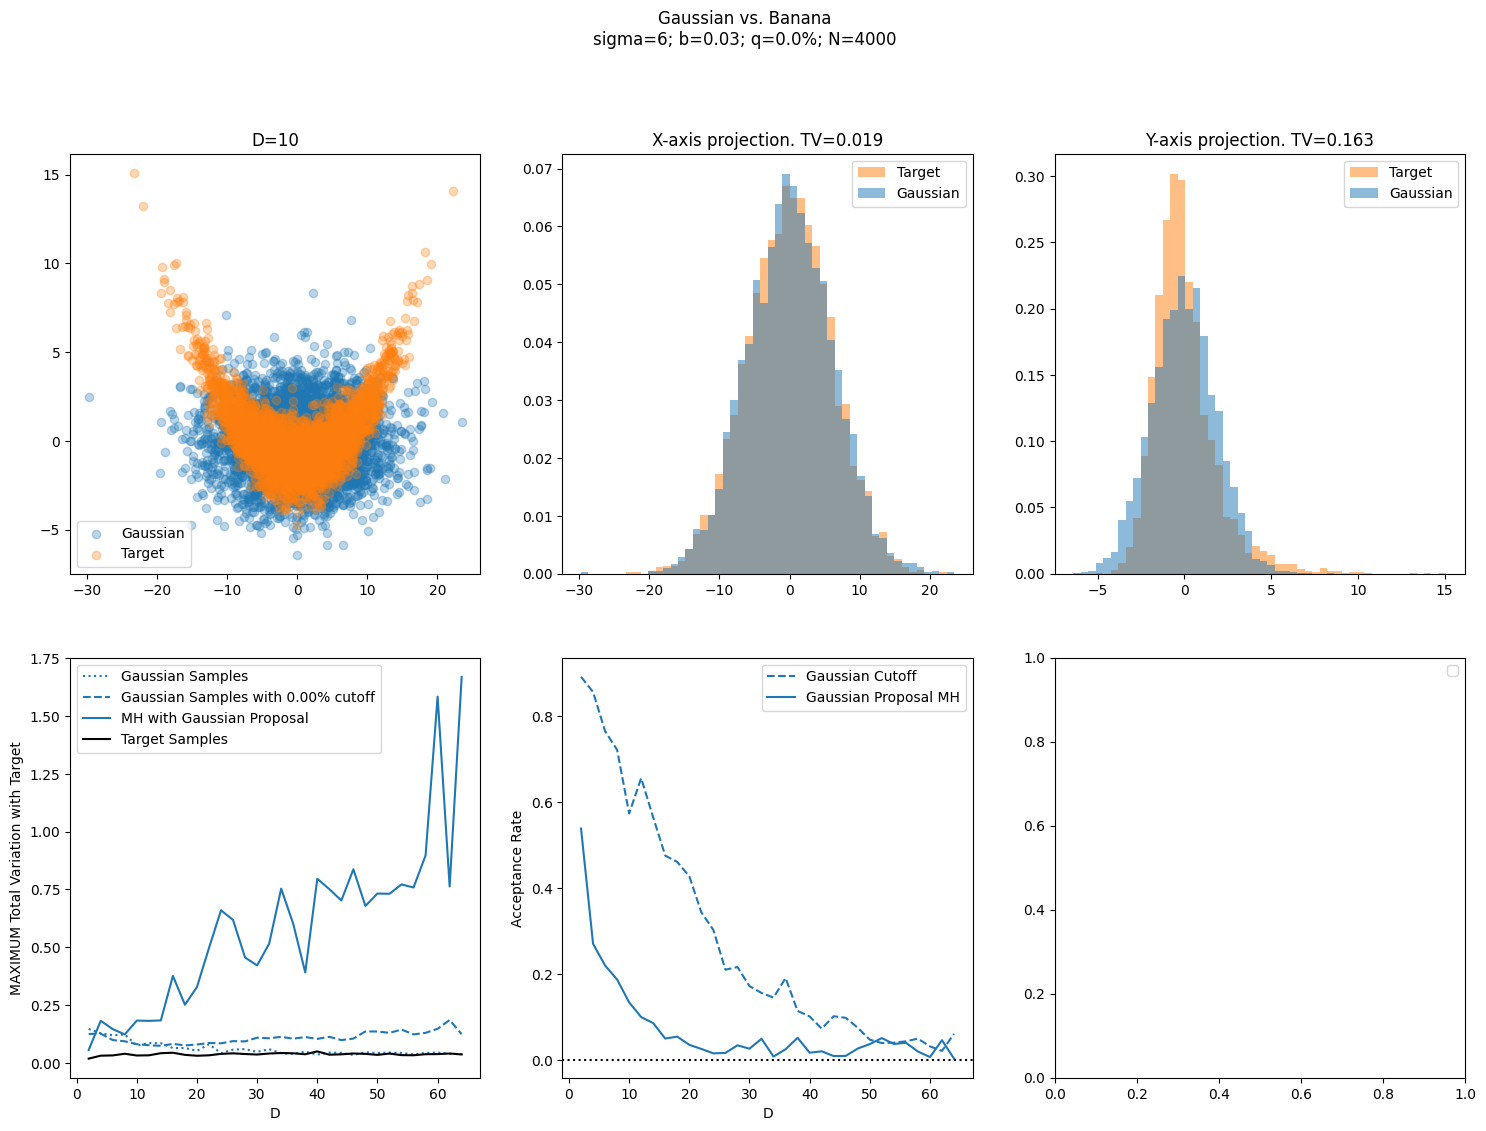

In [35]:
def analyze_gaussian_proposal_atv():
    q = 0.0
    sigma = 6
    b = 0.03
    N = 4000
    alpha = 0.3
    Ds = np.arange(2, 66, 2)
    targets = {D: Banana(dim=D, sigma=sigma, b=b) for D in Ds}

    fig, axs = plt.subplots(figsize=(18, 12), ncols=3, nrows=2)
    fig.suptitle(f'Gaussian vs. Banana\nsigma={sigma}; b={b}; q={100*q}%; N={N}', y=1)

    gaussian_atvs = []
    cut_gaussian_ars = []
    cut_gaussian_atvs = []
    mh_gaussian_ars = []
    mh_gaussian_atvs = []
    self_atvs = []
    
    for D in tqdm(Ds):
        target = targets[D]
        target_samples = target.sample((N,))
        target_log_likelihood = target.log_prob(target_samples)
        target_quantile = target_log_likelihood.quantile(q)
        tv_estimator = lambda samples : sliced_total_variation(target_samples, samples, n_kde_samples=300, n_projections=2*D, mode='max')
        
        gaussian_approx = approximate_with_gaussian(target_samples)
        gaussian_samples = gaussian_approx.sample((N,))
        gaussian_atvs.append(tv_estimator(gaussian_samples))
        acc_rate, cut_indicies = log_prob_cutoff_filter(target, target_quantile, gaussian_samples)
        cut_gaussian_ars.append(acc_rate)
        cut_gaussian_samples = gaussian_samples[cut_indicies]
        cut_gaussian_atvs.append(tv_estimator(cut_gaussian_samples))
        gaussian_log_prob = lambda x : gaussian_approx.log_prob(x)
        acc_rate, mh_indicies = metropolis_hastings_filter(target, cut_gaussian_samples, gaussian_log_prob)
        mh_gaussian_ars.append(acc_rate)
        mh_gaussian_atvs.append(tv_estimator(cut_gaussian_samples[mh_indicies]))
        self_atvs.append(tv_estimator(target.sample((N,))))

        if D == 10:
            proj_dims = (0, 1)
            proj_gaussian_samples = gaussian_samples[:, proj_dims]
            proj_target_samples = target_samples[:, proj_dims]
            ax = axs[0][0]
            ax.scatter(*pl(proj_gaussian_samples), alpha=0.3, label='Gaussian')
            ax.scatter(*pl(proj_target_samples), alpha=0.3, label='Target')
            ax.set_title(f'D={D}')
            ax = axs[0][1]
            ax.hist(
                [to_numpy(proj_gaussian_samples[:, 0]), to_numpy(proj_target_samples[:, 0])],
                bins=50,
                histtype='stepfilled',
                alpha=0.5,
                label=['Gaussian', 'Target'],
                density=True
            )
            x_atv = total_variation_1d(proj_target_samples[:, 0], proj_gaussian_samples[:, 0])
            ax.set_title(f'X-axis projection. TV={x_atv:0.3f}')
            ax = axs[0][2]
            ax.hist(
                [to_numpy(proj_gaussian_samples[:, 1]), to_numpy(proj_target_samples[:, 1])],
                bins=50,
                histtype='stepfilled',
                alpha=0.5,
                label=['Gaussian', 'Target'],
                density=True
            )
            y_atv = total_variation_1d(proj_target_samples[:, 1], proj_gaussian_samples[:, 1])
            ax.set_title(f'Y-axis projection. TV={y_atv:0.3f}')

    ax = axs[1][0]
    ax.plot(Ds, gaussian_atvs, label='Gaussian Samples', color='tab:blue', linestyle=':')
    ax.plot(Ds, cut_gaussian_atvs, label=f'Gaussian Samples with {100*q:0.2f}% cutoff', color='tab:blue', linestyle='--')
    ax.plot(Ds, mh_gaussian_atvs, label='MH with Gaussian Proposal', color='tab:blue')
    ax.plot(Ds, self_atvs, label='Target Samples', color='black')
    ax.set_xlabel('D')
    ax.set_ylabel('MAXIMUM Total Variation with Target')

    ax = axs[1][1]
    ax.plot(Ds, cut_gaussian_ars, label='Gaussian Cutoff', color='tab:blue', linestyle='--')
    ax.plot(Ds, mh_gaussian_ars, label='Gaussian Proposal MH', color='tab:blue')
    ax.axhline(0, color='black', linestyle=':')
    ax.set_xlabel('D')
    ax.set_ylabel('Acceptance Rate')

    for axs_row in axs:
        for ax in axs_row:
            ax.legend()

analyze_gaussian_proposal_atv()

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:10<00:00,  3.54s/it]


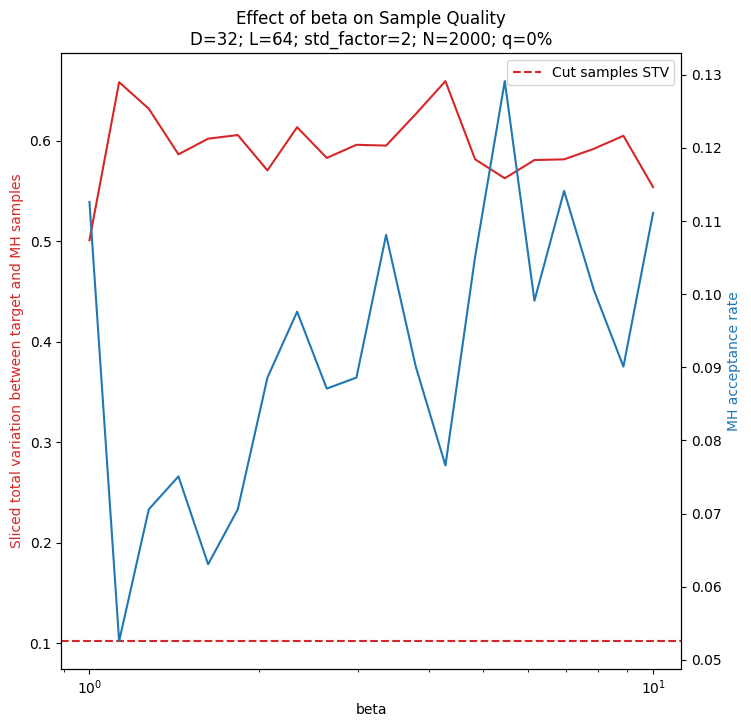

In [28]:
def analyze_effect_of_beta():
    q = 0
    D = 32
    std_factor = 2
    L = 64
    beta_options = np.logspace(0, 1, 20)
    N = 2000

    target = targets[D]
    target_samples = target.sample((N,))
    log_prob_cutoff = get_log_prob_quantile(target, q=q)
    stv_estimator = lambda samples : sliced_total_variation(target_samples, samples, n_kde_samples=300, n_projections=3*D, mode='mean')
    model = get_model(D)
    model.load_knowledge(f'models/{model}_banana.pt')
    model.set_std_factor(std_factor)
    model_samples = model.sample((N,))
    cut_acc_rate, cut_indicies = log_prob_cutoff_filter(target, log_prob_cutoff, model_samples)
    cut_samples = model_samples[cut_indicies]
    cut_stv = stv_estimator(cut_samples[:N//10])

    mh_acc_rates = []
    stvs = []
    for beta in tqdm(beta_options):
        vae_log_prob_estimator = lambda x : model.iw_log_marginal_estimate(x, L=L, beta=beta, batch_L=64)
        mh_acc_rate, mh_indicies = metropolis_hastings_filter(target, cut_samples, vae_log_prob_estimator)
        stv = stv_estimator(cut_samples[mh_indicies])
        mh_acc_rates.append(mh_acc_rate)
        stvs.append(stv)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xscale('log')
    ax.plot(beta_options, stvs, color='tab:red')
    ax.axhline(cut_stv, label='Cut samples STV', color='tab:red', linestyle='--')
    ax.legend()
    ax.set_xlabel('beta')
    ax.set_ylabel('Sliced total variation between target and MH samples', color='tab:red')
    ax2 = ax.twinx()
    ax2.plot(beta_options, mh_acc_rates, color='tab:blue')
    ax2.set_ylabel('MH acceptance rate', color='tab:blue')
    plt.title(f'Effect of beta on Sample Quality\nD={D}; L={L}; std_factor={std_factor}; N={N}; q={100 * q}%')

analyze_effect_of_beta()

In [58]:
def test():
    std_factor = 1
    D = 32
    N = 3000
    target = targets[D]
    target_samples = target.sample((N,))
    target_samples2 = target.sample((N,))
    model = get_model(D)
    model.load_knowledge(f'models/{model}_banana.pt')
    model.set_std_factor(std_factor)
    model_samples = model.sample((N,))
    print('Target vs. Model:', wasserstein_metric(target_samples, model_samples))
    print('Target vs. Target', wasserstein_metric(target_samples, target_samples2))

test()

Target vs. Model: 251.70037807460088
Target vs. Target 265.0443463434469
